## Analysis of NYC 311 complaints

We will be analyzing historical data of New York City 311 complaints from 2010-2020.  The intent of this analysis is generally to identify trends and patterns within the complaint data, so that the Department of Housing Preservation and Development operational managers will be able to more effectively handle the increasing levels of complaints coming in through the 311 service.

### Objectives

Answer the following questions...

1. Which type of complaint should the Department of Housing Preservation and Development of New York City focus on first?
2. Should the Department of Housing Preservation and Development of New York City focus on any particular set of boroughs, ZIP codes, or street (where the complaints are severe) for the specific type of complaints we identified in Question 1?
3. Does the Complaint Type that we identified in response to Question 1 have an obvious relationship with any particular characteristic or characteristics of the houses or buildings?
4. Can a predictive model be built for future prediction of the possibility of complains of the type that we have identified in response to Question 1?

### Setup

Let's import the necessary libraries for this notebook:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

%matplotlib inline

### Read data
We will be accessing data made available from the City of New York about 311 Service Requests.  This data can be found here:

https://data.cityofnewyork.us/Social-Services/311-Service-Requests-from-2010-to-Present/erm2-nwe9


We will also be using data from the PLUTO database made available by NYC later on.  This data can be found here:

https://www1.nyc.gov/assets/planning/download/zip/data-maps/open-data/nyc_pluto_18v1.zip

We'll load a csv file of 311 Service Requests that were only made from 2010-2020 as a pandas dataframe:

In [2]:
#here we will trim down the dataframe to only contain the columns we need
df_data_1 = pd.read_csv('311_Service_Requests_from_2010_to_2020_min.csv')
df = df_data_1[['Created Date','Unique Key','Complaint Type','Incident Zip','Incident Address','Street Name','Address Type','City','Resolution Description','Borough','Latitude','Longitude','Closed Date','Location Type','Status']]
df.head()

,Created Date,Unique Key,Complaint Type,Incident Zip,Incident Address,Street Name,Address Type,City,Resolution Description,Borough,Latitude,Longitude,Closed Date,Location Type,Status
0,02/02/2020 06:09:17 AM,45531130,HEAT/HOT WATER,10019.0,426 WEST 52 STREET,WEST 52 STREET,ADDRESS,NEW YORK,The following complaint conditions are still o...,MANHATTAN,40.765132,-73.988993,NaN,RESIDENTIAL BUILDING,Open
1,02/02/2020 02:15:24 PM,45529784,UNSANITARY CONDITION,11204.0,1751 67 STREET,67 STREET,ADDRESS,BROOKLYN,The following complaint conditions are still o...,BROOKLYN,40.618484,-73.992673,NaN,RESIDENTIAL BUILDING,Open
2,02/02/2020 02:27:41 AM,45527528,HEAT/HOT WATER,11372.0,87-15 37 AVENUE,37 AVENUE,ADDRESS,Jackson Heights,The following complaint conditions are still o...,QUEENS,40.750269,-73.879432,NaN,RESIDENTIAL BUILDING,Open
3,02/02/2020 12:13:18 PM,45530329,HEAT/HOT WATER,10458.0,2405 SOUTHERN BOULEVARD,SOUTHERN BOULEVARD,ADDRESS,BRONX,The following complaint conditions are still o...,BRONX,40.853773,-73.881558,NaN,RESIDENTIAL BUILDING,Open
4,02/02/2020 01:59:44 PM,45528814,APPLIANCE,11209.0,223 78 STREET,78 STREET,ADDRESS,BROOKLYN,The following complaint conditions are still o...,BROOKLYN,40.629745,-74.030533,NaN,RESIDENTIAL BUILDING,Open


In [3]:
#lets confirm the size of this new dataframe
df.shape

(6019843, 15)

In [4]:
#we're going to update dates to be datetime64 format
df[['Created Date', 'Closed Date']] = df[['Created Date', 'Closed Date']].astype('datetime64')
df.dtypes

/Users/noboa/Library/Python/3.8/lib/python/site-packages/pandas/core/frame.py:3188: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


Created Date              datetime64[ns]
Unique Key                         int64
Complaint Type                    object
Incident Zip                     float64
Incident Address                  object
Street Name                       object
Address Type                      object
City                              object
Resolution Description            object
Borough                           object
Latitude                         float64
Longitude                        float64
Closed Date               datetime64[ns]
Location Type                     object
Status                            object
dtype: object

### Data Discovery

Let's do some initial data discovery to get familiar with our dataset (as well as answer some of the edX quiz questions)

In [5]:
#M1Q1: What date is the earliest logged complaint?
print('The earliest logged complaint was filed on', df['Created Date'].min())

The earliest logged complaint was filed on 2010-01-01 00:00:00


In [6]:
#M1Q2: What date is the most recent logged complaint?
print('The most recently logged complaint was filed on', df['Created Date'].max())

The most recently logged complaint was filed on 2020-02-02 23:58:57


In [7]:
#M1Q3: How many incidents have a missing Incident Address?
blank_count = df.isnull().sum()
print('Incident Address has', blank_count['Incident Address'], 'missing values')
blank_count

Incident Address has 52825 missing values


Created Date                   0
Unique Key                     0
Complaint Type                 0
Incident Zip               80697
Incident Address           52825
Street Name                52825
Address Type               84765
City                       80274
Resolution Description      7826
Borough                        0
Latitude                   80671
Longitude                  80671
Closed Date               126657
Location Type              52824
Status                         0
dtype: int64

In [8]:
#M1Q4: How many valid ZIP Codes exist in the Bronx PLUTO dataset?
bronx_pluto = pd.read_csv('BX_18v1.csv')
m1q4 = bronx_pluto.groupby('ZipCode').count()[['PLUTOMapID']]
print('The Bronx PLUTO dataset has', m1q4.shape[0], 'different valid Zip Codes')

The Bronx PLUTO dataset has 26 different valid Zip Codes


/Users/noboa/Library/Python/3.8/lib/python/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (19,20,22,23,64,65,80) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [9]:
#M1Q5: How many valid ZIP Codes exist in the Queens PLUTO dataset?
queens_pluto = pd.read_csv('QN_18v1.csv')
m1q5 = queens_pluto.groupby('ZipCode').count()[['PLUTOMapID']]
print('The Queens PLUTO dataset has', m1q5.shape[0], 'different valid Zip Codes')

/Users/noboa/Library/Python/3.8/lib/python/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (19,20,22,23,64,65,77) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


The Queens PLUTO dataset has 65 different valid Zip Codes


## Problem Statement \#1

Which type of complaint should the Department of Housing Preservation and Development of New York City focus on first?

The next few cells will help answer this question...

In [10]:
#M2Q1: What is the total number of complaints that exist in the dataset?
print('The entire 311 dataset we are using contains', df.shape[0], 'complaints')

The entire 311 dataset we are using contains 6019843 complaints


In [11]:
#M2Q2: How many different Complaint Types are in the dataset?
m2q2 = df.groupby('Complaint Type').count()[['Unique Key']]
print('There are', m2q2.shape[0], 'different Complaint Types in the dataset')
m2q2

There are 30 different Complaint Types in the dataset


,Unique Key
Complaint Type,
AGENCY,9
APPLIANCE,112831
Appliance,4
CONSTRUCTION,5078
DOOR/WINDOW,205278
ELECTRIC,307310
ELEVATOR,6725
Electric,1
FLOORING/STAIRS,137402


In [12]:
#M2Q3: How many complaints of "Elevator" complaint type are there in the dataset?
print('There are', m2q2['Unique Key']['ELEVATOR'], 'Elevator related complaints')

There are 6725 Elevator related complaints


In [13]:
#M2Q4: How many complaints of "Electric" complaint type are there in the dataset?
print('There are', m2q2['Unique Key']['ELECTRIC'] + m2q2['Unique Key']['Electric'], 'Electric related complaints')

There are 307311 Electric related complaints


In [14]:
#M2Q5: How many complaint types have over 800,000 complaints?
print('The following complaint types should be addressed with priority because they drive the highest volumes: \n', m2q2[m2q2['Unique Key'] > 800000])

The following complaint types should be addressed with priority because they drive the highest volumes: 
                 Unique Key
Complaint Type            
HEAT/HOT WATER     1261574
HEATING             887850


## Problem Statement \#2

Should the Department of Housing Preservation and Development of New York City focus on any particular set of boroughs, ZIP codes, or street (where the complaints are severe) for the specific type of complaints you identified in response to Question 1?

The following few cells will help answer this problem statement...

In [15]:
#M3Q1: Which borough contributed the highest volume of complaints towards "Heat/Hot Water" and "Heating" complaint types?
heat_subset = df[(df['Complaint Type'] == 'HEAT/HOT WATER') | (df['Complaint Type'] == 'HEATING')]
heat_subset.head()

,Created Date,Unique Key,Complaint Type,Incident Zip,Incident Address,Street Name,Address Type,City,Resolution Description,Borough,Latitude,Longitude,Closed Date,Location Type,Status
0,2020-02-02 06:09:17,45531130,HEAT/HOT WATER,10019.0,426 WEST 52 STREET,WEST 52 STREET,ADDRESS,NEW YORK,The following complaint conditions are still o...,MANHATTAN,40.765132,-73.988993,NaT,RESIDENTIAL BUILDING,Open
2,2020-02-02 02:27:41,45527528,HEAT/HOT WATER,11372.0,87-15 37 AVENUE,37 AVENUE,ADDRESS,Jackson Heights,The following complaint conditions are still o...,QUEENS,40.750269,-73.879432,NaT,RESIDENTIAL BUILDING,Open
3,2020-02-02 12:13:18,45530329,HEAT/HOT WATER,10458.0,2405 SOUTHERN BOULEVARD,SOUTHERN BOULEVARD,ADDRESS,BRONX,The following complaint conditions are still o...,BRONX,40.853773,-73.881558,NaT,RESIDENTIAL BUILDING,Open
5,2020-02-02 07:52:08,45530344,HEAT/HOT WATER,10456.0,1131 MORRIS AVENUE,MORRIS AVENUE,ADDRESS,BRONX,The following complaint conditions are still o...,BRONX,40.831381,-73.915218,NaT,RESIDENTIAL BUILDING,Open
7,2020-02-02 09:00:54,45527939,HEAT/HOT WATER,11372.0,37-20 81 STREET,81 STREET,ADDRESS,Jackson Heights,The following complaint conditions are still o...,QUEENS,40.749320,-73.885190,NaT,RESIDENTIAL BUILDING,Open


In [16]:
#breakdown for both complaint types by Borough
borough_complaints = heat_subset.groupby(['Borough', 'Complaint Type']).count()[['Unique Key']]
borough_complaints

Unique Key
Borough       Complaint Type            
BRONX         HEAT/HOT WATER      410853
              HEATING             195280
BROOKLYN      HEAT/HOT WATER      384523
              HEATING             190322
MANHATTAN     HEAT/HOT WATER      285526
              HEATING             137513
QUEENS        HEAT/HOT WATER      168318
              HEATING              75804
STATEN ISLAND HEAT/HOT WATER       12353
              HEATING               6015
Unspecified   HEAT/HOT WATER           1
              HEATING             282916

In [17]:
#breakdown for both complaint types by Zip Code
zip_complaints = heat_subset.groupby(['Incident Zip', 'Complaint Type']).count()[['Unique Key']]
zip_complaints.sort_values('Unique Key', ascending=False)

,,Unique Key
Incident Zip,Complaint Type,
11226.0,HEAT/HOT WATER,41786
10458.0,HEAT/HOT WATER,38864
10467.0,HEAT/HOT WATER,38110
10468.0,HEAT/HOT WATER,34507
10453.0,HEAT/HOT WATER,34241
...,...,...
10121.0,HEAT/HOT WATER,1
10112.0,HEAT/HOT WATER,1
10103.0,HEAT/HOT WATER,1


In [18]:
#m3q3.loc[['HEAT/HOT WATER']].sort_values(['Unique Key'], ascending=False)

In [19]:
#M3Q4: Which address had the most complaints filed
heat_subset['Incident Address'].value_counts()

34 ARDEN STREET                   13858
89-21 ELMHURST AVENUE             11548
3810 BAILEY AVENUE                 7115
1025 BOYNTON AVENUE                5785
9511 SHORE ROAD                    5006
                                  ...  
358 JAMAICA AVENUE                    1
727 FENIMORE STREET                   1
2601 HARWAY AVENUE                    1
113-19 FRANCIS LEWIS BOULEVARD        1
54-17 151 STREET                      1
Name: Incident Address, Length: 136949, dtype: int64

In [20]:
#M3Q5: How many complaints have been closed (i.e. have a valid Closed Date)
heat_subset['Closed Date'].notnull().value_counts()

True     2133429
False      15995
Name: Closed Date, dtype: int64

## Problem Statement \#3

Does the Complaint Type that you identified in response to Question 1 have an obvious relationship with any particular characteristic or characteristic of the Houses?

We'll be focusing on the Bronx borough for this question, because it is the borough with the highest volume on complaints.

The following few cells will help answer this problem statement...

In [21]:
#we will subset the original PLUTO dataset to preserve memory
bronx_pluto = bronx_pluto[['Address', 'BldgArea', 'BldgDepth', 'BuiltFAR', 'CommFAR', 'FacilFAR', 'Lot', 'LotArea', 'LotDepth', 'NumBldgs', 'NumFloors', 'OfficeArea', 'ResArea', 'ResidFAR', 'RetailArea', 'YearBuilt', 'YearAlter1', 'ZipCode', 'YCoord', 'XCoord']]
bronx_pluto.head()

,Address,BldgArea,BldgDepth,BuiltFAR,CommFAR,FacilFAR,Lot,LotArea,LotDepth,NumBldgs,NumFloors,OfficeArea,ResArea,ResidFAR,RetailArea,YearBuilt,YearAlter1,ZipCode,YCoord,XCoord
0,122 BRUCKNER BOULEVARD,0,0.0,0.00,5.0,6.5,1,15000,200.0,1,0.0,0,0,6.02,0,0,0,10454.0,232162.0,1005957.0
1,126 BRUCKNER BOULEVARD,752,16.0,0.05,5.0,6.5,4,13770,100.0,2,1.0,272,0,6.02,0,1931,1994,10454.0,232156.0,1006076.0
2,138 BRUCKNER BOULEVARD,39375,200.0,1.13,5.0,6.5,10,35000,200.0,1,2.0,0,0,6.02,0,1931,0,10454.0,232036.0,1006187.0
3,144 BRUCKNER BOULEVARD,12500,85.0,5.00,5.0,6.5,17,2500,100.0,1,5.0,0,12500,6.02,0,1931,2001,10454.0,232033.0,1006299.0
4,148 BRUCKNER BOULEVARD,8595,70.0,4.58,5.0,6.5,18,1875,75.0,1,5.0,0,6876,6.02,1719,1920,2009,10454.0,232040.0,1006363.0


In [22]:
#M4Q1: Determine the age of buildings from the PLUTO dataset
bronx_pluto = bronx_pluto.assign(BldgAge=lambda x: 2020-x.YearBuilt)
bronx_pluto.head()

,Address,BldgArea,BldgDepth,BuiltFAR,CommFAR,FacilFAR,Lot,LotArea,LotDepth,NumBldgs,...,OfficeArea,ResArea,ResidFAR,RetailArea,YearBuilt,YearAlter1,ZipCode,YCoord,XCoord,BldgAge
0,122 BRUCKNER BOULEVARD,0,0.0,0.00,5.0,6.5,1,15000,200.0,1,...,0,0,6.02,0,0,0,10454.0,232162.0,1005957.0,2020
1,126 BRUCKNER BOULEVARD,752,16.0,0.05,5.0,6.5,4,13770,100.0,2,...,272,0,6.02,0,1931,1994,10454.0,232156.0,1006076.0,89
2,138 BRUCKNER BOULEVARD,39375,200.0,1.13,5.0,6.5,10,35000,200.0,1,...,0,0,6.02,0,1931,0,10454.0,232036.0,1006187.0,89
3,144 BRUCKNER BOULEVARD,12500,85.0,5.00,5.0,6.5,17,2500,100.0,1,...,0,12500,6.02,0,1931,2001,10454.0,232033.0,1006299.0,89
4,148 BRUCKNER BOULEVARD,8595,70.0,4.58,5.0,6.5,18,1875,75.0,1,...,0,6876,6.02,1719,1920,2009,10454.0,232040.0,1006363.0,100


In [23]:
# we are going to subset and clean our data in order to visualize the distribution of building ages
age_counts = bronx_pluto['BldgAge'].value_counts().to_frame()
age_counts.drop(2020, inplace=True)
age_counts.reset_index(inplace=True)
age_counts.rename(columns={'index': 'Building_Age', 'BldgAge': 'count'}, inplace=True)
age_counts.head()

,Building_Age,count
0,100,7550
1,95,6343
2,90,5856
3,70,5307
4,60,4577


<AxesSubplot:xlabel='Building_Age', ylabel='count'>

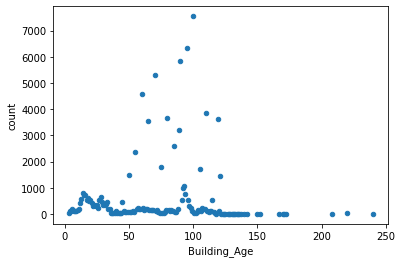

In [24]:
# constructing the scatter plot
age_counts.plot(kind='scatter', x='Building_Age', y='count')

In [26]:
#M4Q2: Do any relationships exist between the building characteristics and number of complaints?
zipcode_counts = df['Incident Zip'].value_counts()
# zipcode_counts.reset_index(inplace=True)
zipcode_counts


11226.0    215709
10467.0    173911
10458.0    169485
10453.0    162532
10468.0    148213
            ...  
10279.0         1
10121.0         1
12345.0         1
10045.0         1
10271.0         1
Name: Incident Zip, Length: 202, dtype: int64

In [ ]:
zipcode_counts

In [ ]:
zipcode_lk

In [ ]:
bronx_pluto['ZipIncidents'] = df.lookup(bronx_pluto['ZipCode'], zipcode_counts['count'])

## Model Development

Based on the features available that are related to Complaint Types, we will try to put together a Random Forest and XGBoost model.


### Problem Statement \#4

Can a predictive model be built for future prediction of the possibility of complaints of the specific type that you identified in response to Question 1?

The following few cells will help answer this problem statement...

In [ ]:
bronx_pluto.applymap()